# Finding Heavy Traffic Indicators on I-94

We are going to analyze a dataset about the westbound traffic on the [I-94 Interstate Highway](https://en.wikipedia.org/wiki/Interstate_94).

John Hogue made the dataset available, and you can download it from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume).

The goal of our analysis is to determine a few indicators of heavy traffic on I-94. These indicators can be weather type, time of the day, time of the week, etc. For instance, we may find out that the traffic is usually heavier in the summer or when it snows.

## The I-94 Traffic Dataset

In [1]:
import pandas as pd

ds = pd.read_csv('Metro_Interstate_Traffic_Volume.csv')
ds.head() #Prints first 5 rows

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [2]:
ds.tail() #Prints last 5 rows

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
48199,None,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
48200,None,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
48201,None,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159
48202,None,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450
48203,None,282.12,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 23:00:00,954


In [3]:
ds.info() #Prints info of dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


The dataset has 48204 entries and 9 columns. There are no null values. Each entry shows the weather and traffic data for a specific hour - we have data from 2012-10-02 09:00:00 to 2018-09-30 23:00:00.

The [dataset documentation](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume) mentions that a station located approximately midway between Minneapolis and Saint Paul recorded the traffic data. Also, the station only records westbound traffic (cars moving from east to west).

This means that the results of our analysis will be about the westbound traffic in the proximity of that station. In other words, we should avoid generalizing our results for the entire I-94 highway.


## Analysing Traffic Volume

We are going to start our analysis by examining the distribution of the traffic_volume column

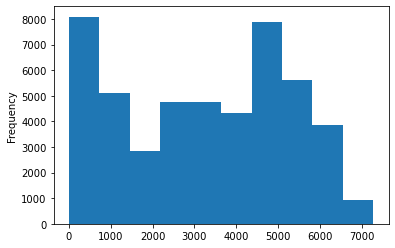

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
ds['traffic_volume'].plot.hist()
plt.show()

In [10]:
ds['traffic_volume'].describe()

count    48204.000000
mean      3259.818355
std       1986.860670
min          0.000000
25%       1193.000000
50%       3380.000000
75%       4933.000000
max       7280.000000
Name: traffic_volume, dtype: float64

Between 2012-10-02 09:00:00 and 2018-09-30 23:00:00, the hourly traffic volume varied from 0 to 7,280 cars, with an average of 3,260 cars.

We can make more interesting observations:-

- About 25% of the time, there were only 1,193 cars or fewer passing the station each hour - this probably occurs during the night, or when a road is under construction. 
- However, about 25% of the time, the traffic volume was four times as much (4,933 cars or more).

This possibility that nighttime and daytime might influence traffic volume gives our analysis an interesting direction: comparing daytime with nighttime data.

## Traffic Volume: Day vs Night

We'll start by dividing the dataset into two parts:

- Daytime data: hours from 7 a.m. to 7 p.m. (12 hours)
- Nighttime data: hours from 7 p.m. to 7 a.m. (12 hours)

While this is not a perfect criterion for distinguishing between nighttime and daytime, it's a good starting point.

In [15]:
ds['date_time'] = pd.to_datetime(ds['date_time'])

day = ds.copy()[(ds['date_time'].dt.hour >= 7) & (ds['date_time'].dt.hour < 19)]
print(day.shape)

night = ds.copy()[(ds['date_time'].dt.hour >= 19) | (ds['date_time'].dt.hour < 7)]
print(night.shape)

(23877, 9)
(24327, 9)


This significant difference in row numbers between day and night is due to a few hours of missing data. For instance, if you look at rows 176 and 177, you'll notice there's no data for two hours (4 and 5).

In [16]:
ds.iloc[176:178]

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
176,None,281.17,0.0,0.0,90,Clouds,overcast clouds,2012-10-10 03:00:00,361
177,None,281.25,0.0,0.0,92,Clear,sky is clear,2012-10-10 06:00:00,5875


## Traffic Volume: Day vs. Night (II)


Now we're going to compare the traffic volume at night and during day by plotting histograms side-by-side using a grid chart



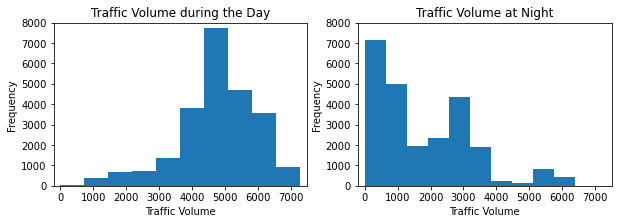

In [23]:
plt.figure(figsize=(10,3)) 

plt.subplot(1,2,1)
plt.hist(day['traffic_volume'])
plt.title('Traffic Volume during the Day')
plt.xlim(-200,7500)
plt.ylim(0,8000)
plt.xlabel('Traffic Volume')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
plt.hist(night['traffic_volume'])
plt.title('Traffic Volume at Night')
plt.xlim(-200,7500)
plt.ylim(0,8000)
plt.xlabel('Traffic Volume')
plt.ylabel('Frequency')

plt.show()




In [26]:
day['traffic_volume'].describe()

count    23877.000000
mean      4762.047452
std       1174.546482
min          0.000000
25%       4252.000000
50%       4820.000000
75%       5559.000000
max       7280.000000
Name: traffic_volume, dtype: float64

In [27]:
night['traffic_volume'].describe()

count    24327.000000
mean      1785.377441
std       1441.951197
min          0.000000
25%        530.000000
50%       1287.000000
75%       2819.000000
max       6386.000000
Name: traffic_volume, dtype: float64

From the first histogram, we can infer that the distribution of traffic volume during the day is left skewed. This means that most of the traffic volume values are high - there are 4,252 or more cars passing the station each hour 75% of the time (because 25% of values are less than 4,252).

The histogram displaying the nighttime data is right skewed. This means that most of the traffic volume values are low - 75% of the time, the number of cars that passed the station each hour was less than 2,819.

Although there are still measurements of over 5,000 cars per hour, the traffic at night is generally light. Our goal is to find indicators of heavy traffic, so we'll only focus on the daytime data moving forward.

## Time Indicators

One of the possible indicators of heavy traffic is time. There might be more people on the road in a certain month, on a certain day, or at a certain time of day.

We're going to look at a few line plots showing how the traffic volume changes according to the following:

- Month
- Day of the week
- Time of day

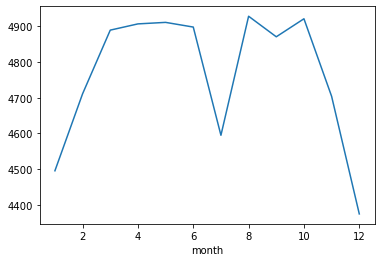

In [34]:
day['month'] = day['date_time'].dt.month
by_month = day.groupby('month').mean()
by_month['traffic_volume'].plot.line()
plt.show()

The traffic looks less heavy during cold months (November–February) and more intense during warm months (March–October), with one interesting exception: July. Is there anything special about July? Is traffic significantly less heavy in July each year?

To answer the last question, let's see how the traffic volume changed each year in July.

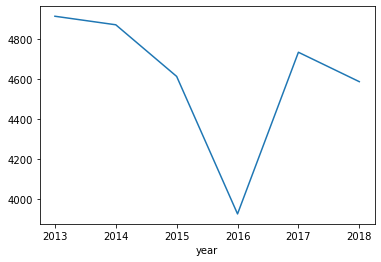

In [43]:
day['year'] = day['date_time'].dt.year
only_july = day[day['month'] == 7]
only_july.groupby('year').mean()['traffic_volume'].plot.line()
plt.show()

Typically, the traffic is pretty heavy in July, similar to the other warm months. The only exception we see is 2016, which had a high decrease in traffic volume. One possible reason for this is road construction - [this article](https://www.crainsdetroit.com/article/20160728/NEWS/160729841/weekend-construction-i-96-us-23-bridge-work-i-94-lane-closures-i-696) from 2016 supports this hypothesis.

As a tentative conclusion here, we can say that warm months generally show heavier traffic compared to cold months. In a warm month, you can can expect for each hour of daytime a traffic volume close to 5,000 cars.

## Time Indicators (II)
Let's now look at a more granular indicator: day number.

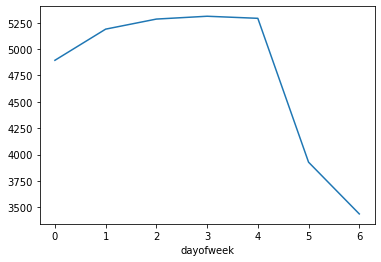

In [44]:
day['dayofweek'] = day['date_time'].dt.dayofweek
by_dayofweek = day.groupby('dayofweek').mean()
by_dayofweek['traffic_volume'].plot.line()
plt.show()

Traffic volume is significantly heavier on business days (Monday – Friday). Except for Monday, we only see values over 5,000 during business days. Traffic is lighter on weekends, with values below 4,000 cars.

## Time Indicators (III)
We'll now generate a line plot for the time of day. The weekends, however, will drag down the average values, so we're going to look at the averages separately. To do that, we'll start by splitting the data based on the day type: business day or weekend.

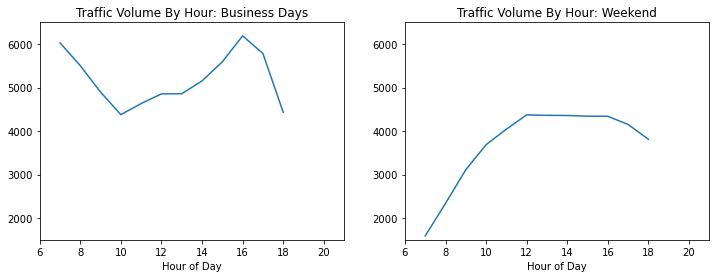

In [52]:
day['hour'] = day['date_time'].dt.hour
business_days = day.copy()[day['dayofweek'] <= 4]  # 4 == Friday
weekend = day.copy()[day['dayofweek'] > 4]  # 5 == Saturday
by_hour_business = business_days.groupby('hour').mean()
by_hour_weekend = weekend.groupby('hour').mean()

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
by_hour_business['traffic_volume'].plot.line()
plt.xlim(6,21)
plt.ylim(1500,6500)
plt.xlabel('Hour of Day')
plt.title('Traffic Volume By Hour: Business Days')

plt.subplot(1,2,2)
by_hour_weekend['traffic_volume'].plot.line()
plt.xlim(6,21)
plt.ylim(1500,6500)
plt.xlabel('Hour of Day')
plt.title('Traffic Volume By Hour: Weekend')

plt.show()


At each hour of the day, the traffic volume is generally higher during business days compared to the weekends. As somehow expected, the rush hours are around 7 and 16 - when most people travel from home to work and back. We see volumes of over 6,000 cars at rush hours.

To summarize, we found a few time-related indicators of heavy traffic:

- The traffic is usually heavier during warm months (March–October) compared to cold months (November–February).
- The traffic is usually heavier on business days compared to weekends.
- On business days, the rush hours are around 7 and 16.

## Weather Indicators
Another possible indicator of heavy traffic is weather. The dataset provides us with a few useful columns about weather: temp, rain_1h, snow_1h, clouds_all, weather_main, weather_description.

A few of these columns are numerical, so let's start by looking up their correlation values with traffic_volume.

In [56]:
day.corr()['traffic_volume']

temp              0.128317
rain_1h           0.003697
snow_1h           0.001265
clouds_all       -0.032932
traffic_volume    1.000000
month            -0.022337
year             -0.003557
dayofweek        -0.416453
hour              0.172704
Name: traffic_volume, dtype: float64

Temperature shows the strongest correlation with a value of just +0.13. The other relevant columns (rain_1h, snow_1h, clouds_all) don't show any strong correlation with traffic_value. 

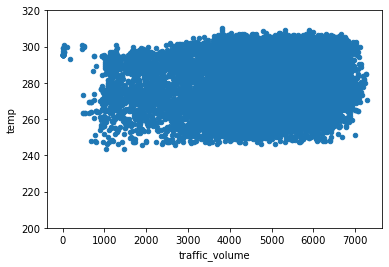

In [59]:
day.plot.scatter('traffic_volume', 'temp')
plt.ylim(200, 320) # two wrong 0K temperatures mess up the y-axis
plt.show()

We can conclude that temperature doesn't look like a solid indicator of heavy traffic.

To see if we can find more useful data, we'll look next at the categorical weather-related columns: weather_main and weather_description.



## Weather Types

We're going to calculate the average traffic volume associated with each unique value in these two columns.

To start, we're going to plot a horizontal bar plot which shows the traffic_volume averages for each weather_main component.

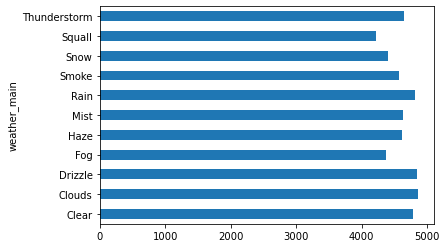

In [65]:
by_weather_main = day.groupby('weather_main').mean()
by_weather_main['traffic_volume'].plot.barh()
plt.show()

It looks like there's no weather type where traffic volume exceeds 5,000 cars. This makes finding a heavy traffic indicator more difficult. Let's also group by weather_description, which has a more granular weather classification.

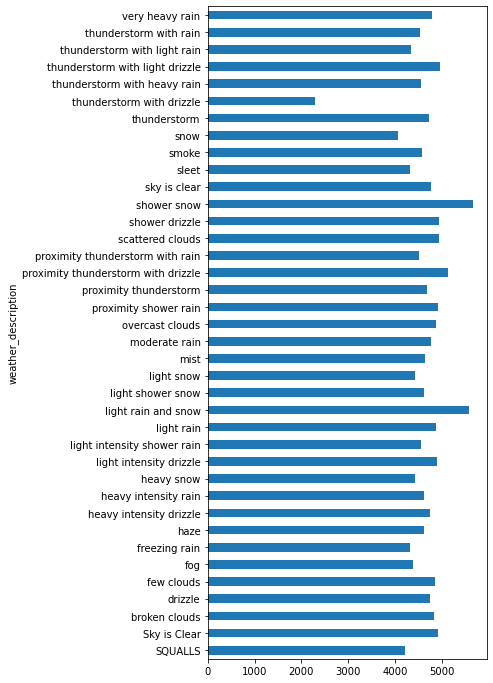

In [71]:
by_weather_description = day.groupby('weather_description').mean()
by_weather_description['traffic_volume'].plot.barh(figsize=(5,12))
plt.show()

It looks like there are three weather types where traffic volume exceeds 5,000:

- Shower snow
- Light rain and snow
- Proximity thunderstorm with drizzle

It's not clear why these weather types have the highest average traffic values — this is bad weather, but not that bad. Perhaps more people take their cars out of the garage when the weather is bad instead of riding a bike or walking.

## Conclusion
In this project, we tried to find a few indicators of heavy traffic on the I-94 Interstate highway. We managed to find two types of indicators:

- Time indicators
    - The traffic is usually heavier during warm months (March–October) compared to cold months (November–February).
    - The traffic is usually heavier on business days compared to the weekends.
    - On business days, the rush hours are around 7 and 16.

- Weather indicators
    - Shower snow
    - Light rain and snow
    - Proximity thunderstorm with drizzle